<a href="https://colab.research.google.com/github/icapucap/capsnet/blob/master/capsnetmimic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CapsNet - Capsule Networks**

##### This is an implementation of the paper *Sabour et. al*. - [Dynamic Routing Between Capsules](https://arxiv.org/abs/1710.09829) as part of the course IT 290 Seminar course.


---


# **Introduction**

### **Problem with CNNs:**

##### CNNs perform exceptionally great when they are classifying images which are very close to the data set. If the images have rotation, tilt or any other different orientation then CNNs have poor performance. This problem was solved by adding different variations of the same image during training. In CNN each layer understands an image at a much more granular level. We use pooling after each layer to make it compute in reasonable time frames. But in essence it also loses out the positional data.

##### Pooling helps in creating the positional invariance. Otherwise CNNs would fit only for images or data which are very close to the training set. This invariance also leads to triggering false positive for images which have the components of a ship but not in the correct order.

### **Capsules: Motivation and advantages**

##### A Capsule is a nested set of neural layers. So in a regular neural network you keep on adding more layers. In CapsNet you would add more layers inside a single layer. A capsule outputs a vector to represent the existence of the entity. The orientation of the vector represents the properties of the entity. The vector is sent to all possible parents in the neural network. For each possible parent a capsule can find a prediction vector. Prediction vector is calculated based on multiplying it’s own weight and a weight matrix. Whichever parent has the largest scalar prediction vector product, increases the capsule bond. Rest of the parents decrease their bond. This routing by agreement method is superior than the current mechanism like max-pooling. Max pooling routes based on the strongest feature detected in the lower layer. 

In [0]:
import tensorflow as tf

In [0]:
X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X")

AttributeError: ignored

In [0]:
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6  # 1152 primary capsules
caps1_n_dims = 8

### **The next cell defines the parameters for the 2 convolutional layers that will be used to build the CapsNet**




In [0]:
conv1_params = {
    "filters": 256,
    "kernel_size": 9,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu,
}

conv2_params = {
    "filters": caps1_n_maps * caps1_n_dims, # 256 convolutional filters
    "kernel_size": 9,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu
}

In [0]:
conv1 = tf.layers.conv2d(X, name="conv1", **conv1_params)
conv2 = tf.layers.conv2d(conv1, name="conv2", **conv2_params)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [0]:
caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims],
                       name="caps1_raw")


# **Squashing**

##### Squashing is a non-linearity operation. So instead of adding squashing to each layer like how one would do in a convolutional network, one would add the squashing to a nested set of layers. So the squashing function gets applied to the vector output of each capsule.

##### The paper introduces a new squashing operation.

![alt text](https://pechyonkin.me/images/201711-capsules-2/squash.png)

##### ReLU or similar non linearity functions work well with single neurons. But the paper found that this squashing function works best with capsules. This tries to squash the length of output vector of a capsule. It squashes to 0 if it is a small vector and tries to limit the output vector to 1 if the vector is long. The dynamic routing adds some extra computation cost. But it definitely gives added advantage.



In [0]:
def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)  # Squashing
        unit_vector = s / safe_norm                         # Unit scaling
        return squash_factor * unit_vector

In [0]:
caps1_output = squash(caps1_raw, name="caps1_output")

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [0]:
caps2_n_caps = 10
caps2_n_dims = 16

In [0]:
init_sigma = 0.1

W_init = tf.random_normal(
    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
    stddev=init_sigma, dtype=tf.float32, name="W_init")
W = tf.Variable(W_init, name="W")

In [0]:
batch_size = tf.shape(X)[0]
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")

In [0]:
caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                       name="caps1_output_expanded")
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2,
                                   name="caps1_output_tile")
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1],
                             name="caps1_output_tiled")

In [0]:
W_tiled

<tf.Tensor 'W_tiled:0' shape=(?, 1152, 10, 16, 8) dtype=float32>

In [0]:
caps1_output_tiled

<tf.Tensor 'caps1_output_tiled:0' shape=(?, 1152, 10, 8, 1) dtype=float32>

In [0]:
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled,
                            name="caps2_predicted")

In [0]:
caps2_predicted

<tf.Tensor 'caps2_predicted:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

In [0]:
import numpy as np
raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1],
                       dtype=np.float32, name="raw_weights")

# **Dynamic routing**



##### A capsule i in a lower-level layer needs to decide how to send its output vector to higher-level capsules j. It makes this decision by changing scalar weight C(i,j) that will multiply its output vector and then be treated as input to a higher-level capsule. 

#### **"Lower level capsule will send its input to the higher level capsule that “agrees” with its input. This is the essence of the dynamic routing algorithm."**

![alt text](https://miro.medium.com/max/2548/1*ukE9EQ6Yd6IPIu1cLJWSEQ.png)

*   This procedure takes all capsules in a lower level l and their outputs u^, as well as the number of routing iterations r. The algorithm will produce the output of a higher level capsule vj. Essentially, this algorithm tells us how to calculate forward pass of the network.

*  Step in line 4 calculates the value of vector ci which is all routing weights for a lower level capsule i. This is done for all lower level capsules. Softmax enforces probabilistic nature of coefficients cij that I described above.

* At the first iteration, the value of all coefficients cij will be equal and represents the state of maximum confusion and uncertainty: lower level capsules have no idea which higher level capsules will best fit their output. 

* Line 5 is where we look at higher level capsules. This step calculates a linear combination of input vectors, weighted by routing coefficients cij, determined in the previous step. Intuitively, this means scaling down input vectors and adding them together, which produces output vector sj. This is done for all higher level capsules.

* Next, in line 6 vectors from last step are passed through the squash nonlinearity, that makes sure the direction of the vector is preserved, but its length is enforced to be no more than 1. This step produces the output vector vj for all higher level capsules.





In [0]:
routing_weights = tf.nn.softmax(raw_weights, dim=2, name="routing_weights")

Instructions for updating:
dim is deprecated, use axis instead


In [0]:
weighted_predictions = tf.multiply(routing_weights, caps2_predicted,
                                   name="weighted_predictions")
weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keep_dims=True,
                             name="weighted_sum")

In [0]:
caps2_output_round_1 = squash(weighted_sum, axis=-2,
                              name="caps2_output_round_1")

In [0]:
caps2_output_round_1

<tf.Tensor 'caps2_output_round_1/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

In [0]:
caps2_predicted

<tf.Tensor 'caps2_predicted:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

In [0]:
caps2_output_round_1

<tf.Tensor 'caps2_output_round_1/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

In [0]:
caps2_output_round_1_tiled = tf.tile(
    caps2_output_round_1, [1, caps1_n_caps, 1, 1, 1],
    name="caps2_output_round_1_tiled")

In [0]:
agreement = tf.matmul(caps2_predicted, caps2_output_round_1_tiled,
                      transpose_a=True, name="agreement")

In [0]:
raw_weights_round_2 = tf.add(raw_weights, agreement,
                             name="raw_weights_round_2")

In [0]:
routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2,
                                        dim=2,
                                        name="routing_weights_round_2")
weighted_predictions_round_2 = tf.multiply(routing_weights_round_2,
                                           caps2_predicted,
                                           name="weighted_predictions_round_2")
weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2,
                                     axis=1, keep_dims=True,
                                     name="weighted_sum_round_2")
caps2_output_round_2 = squash(weighted_sum_round_2,
                              axis=-2,
                              name="caps2_output_round_2")

In [0]:
caps2_output = caps2_output_round_2

In [0]:
def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

In [0]:
y_proba = safe_norm(caps2_output, axis=-2, name="y_proba")

In [0]:
y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_proba")

In [0]:
y_proba_argmax

<tf.Tensor 'y_proba_1:0' shape=(?, 1, 1) dtype=int64>

In [0]:
y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")

In [0]:
y_pred

<tf.Tensor 'y_pred:0' shape=(?,) dtype=int64>

In [0]:
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")

In [0]:
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

In [0]:
T = tf.one_hot(y, depth=caps2_n_caps, name="T")

In [0]:
caps2_output

<tf.Tensor 'caps2_output_round_2/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

In [0]:
caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True,
                              name="caps2_output_norm")

In [0]:
present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm),
                              name="present_error_raw")
present_error = tf.reshape(present_error_raw, shape=(-1, 10),
                           name="present_error")

In [0]:
absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus),
                             name="absent_error_raw")
absent_error = tf.reshape(absent_error_raw, shape=(-1, 10),
                          name="absent_error")

In [0]:
L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,
           name="L")

In [0]:
margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

In [0]:
mask_with_labels = tf.placeholder_with_default(False, shape=(),
                                               name="mask_with_labels")

In [0]:
reconstruction_targets = tf.cond(mask_with_labels, # condition
                                 lambda: y,        # if True
                                 lambda: y_pred,   # if False
                                 name="reconstruction_targets")

In [0]:
reconstruction_mask = tf.one_hot(reconstruction_targets,
                                 depth=caps2_n_caps,
                                 name="reconstruction_mask")

In [0]:
reconstruction_mask

<tf.Tensor 'reconstruction_mask:0' shape=(?, 10) dtype=float32>

In [0]:
caps2_output

<tf.Tensor 'caps2_output_round_2/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

In [0]:
reconstruction_mask_reshaped = tf.reshape(
    reconstruction_mask, [-1, 1, caps2_n_caps, 1, 1],
    name="reconstruction_mask_reshaped")

In [0]:
caps2_output_masked = tf.multiply(
    caps2_output, reconstruction_mask_reshaped,
    name="caps2_output_masked")

In [0]:
caps2_output_masked

<tf.Tensor 'caps2_output_masked:0' shape=(?, 1, 10, 16, 1) dtype=float32>

In [0]:
decoder_input = tf.reshape(caps2_output_masked,
                           [-1, caps2_n_caps * caps2_n_dims],
                           name="decoder_input")

In [0]:
decoder_input

<tf.Tensor 'decoder_input:0' shape=(?, 160) dtype=float32>

In [0]:
n_hidden1 = 512
n_hidden2 = 1024
n_output = 28 * 28

In [0]:
with tf.name_scope("decoder"):
    hidden1 = tf.layers.dense(decoder_input, n_hidden1,
                              activation=tf.nn.relu,
                              name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2,
                              activation=tf.nn.relu,
                              name="hidden2")
    decoder_output = tf.layers.dense(hidden2, n_output,
                                     activation=tf.nn.sigmoid,
                                     name="decoder_output")

Instructions for updating:
Use keras.layers.Dense instead.


In [0]:
X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
squared_difference = tf.square(X_flat - decoder_output,
                               name="squared_difference")
reconstruction_loss = tf.reduce_mean(squared_difference,
                                    name="reconstruction_loss")

In [0]:
alpha = 0.0005

loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")

In [0]:
correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [0]:
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name="training_op")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [0]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [0]:
# from tensorflow.examples.tutorials.mnist import input_data

# mnist = input_data.read_data_sets("/tmp/data/")
import tensorflow as tf
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


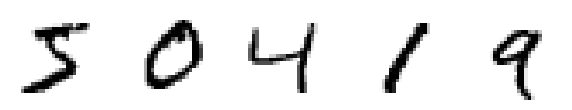

In [0]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = train_images[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

In [0]:

mnist.train.labels[:n_samples]

array([7, 3, 4, 6, 1], dtype=uint8)

In [0]:
n_epochs = 5
batch_size = 50
restore_checkpoint = True

n_iterations_per_epoch = mnist.train.num_examples // batch_size
n_iterations_validation = mnist.validation.num_examples // batch_size
best_loss_val = np.infty
checkpoint_path = "./my_capsule_network"

with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()

    for epoch in range(n_epochs):
        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            # Run the training operation and measure the loss:
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch,
                           mask_with_labels: True})
            print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")

        # At the end of each epoch,
        # measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch, y_batch = mnist.validation.next_batch(batch_size)
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

Instructions for updating:
Use standard file APIs to check for files with this prefix.
Epoch: 1  Val accuracy: 98.9000%  Loss: 0.013539 (improved)
Epoch: 2  Val accuracy: 99.1600%  Loss: 0.010620 (improved)
Epoch: 3  Val accuracy: 99.2000%  Loss: 0.009028 (improved)
Epoch: 4  Val accuracy: 99.4000%  Loss: 0.007414 (improved)
Epoch: 5  Val accuracy: 99.3600%  Loss: 0.007599


In [0]:
n_iterations_test = mnist.test.num_examples // batch_size

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    loss_tests = []
    acc_tests = []
    for iteration in range(1, n_iterations_test + 1):
        X_batch, y_batch = mnist.test.next_batch(batch_size)
        loss_test, acc_test = sess.run(
                [loss, accuracy],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch})
        loss_tests.append(loss_test)
        acc_tests.append(acc_test)
        print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                  iteration, n_iterations_test,
                  iteration * 100 / n_iterations_test),
              end=" " * 10)
    loss_test = np.mean(loss_tests)
    acc_test = np.mean(acc_tests)
    print("\rFinal test accuracy: {:.4f}%  Loss: {:.6f}".format(
        acc_test * 100, loss_test))

INFO:tensorflow:Restoring parameters from ./my_capsule_network
Final test accuracy: 99.3500%  Loss: 0.007409


In [0]:
n_samples = 5

sample_images = mnist.test.images[:n_samples].reshape([-1, 28, 28, 1])

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    caps2_output_value, decoder_output_value, y_pred_value = sess.run(
            [caps2_output, decoder_output, y_pred],
            feed_dict={X: sample_images,
                       y: np.array([], dtype=np.int64)})

INFO:tensorflow:Restoring parameters from ./my_capsule_network


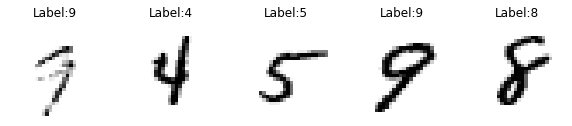

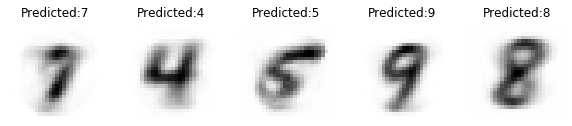

In [0]:
sample_images = sample_images.reshape(-1, 28, 28)
reconstructions = decoder_output_value.reshape([-1, 28, 28])

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(sample_images[index], cmap="binary")
    plt.title("Label:" + str(mnist.test.labels[index]))
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.title("Predicted:" + str(y_pred_value[index]))
    plt.imshow(reconstructions[index], cmap="binary")
    plt.axis("off")
    
plt.show()
